In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# get all normal useragents data
def get_all_normaluseragents_df(count : int = 100):
    df_firefox = pd.read_csv("data_collection/firefox.csv")
    df_chrome = pd.read_csv("data_collection/chrome.csv")
    df_ie = pd.read_csv("data_collection/internet-explorer.csv")
    df_opera = pd.read_csv("data_collection/opera.csv")
    df_safari = pd.read_csv("data_collection/safari.csv")
    df_android = pd.read_csv("data_collection/android-browser.csv")

    df_firefox.drop(["version","commonality"],axis=1,inplace=True)
    df_chrome.drop(["version","commonality"],axis=1,inplace=True)
    df_ie.drop(["version","commonality"],axis=1,inplace=True)
    df_opera.drop(["version","commonality"],axis=1,inplace=True)
    df_safari.drop(["version","commonality"],axis=1,inplace=True)
    df_android.drop(["version","commonality"],axis=1,inplace=True)

    firefox_ua =  df_firefox.head(count)
    chrome_ua =  df_chrome.head(count)
    ie_ua =  df_ie.head(count)
    safari_ua =  df_safari.head(count)
    android_ua =  df_android.head(count)

    useragents = pd.concat([firefox_ua , chrome_ua , ie_ua , safari_ua , android_ua] , axis=0)
    shuffled_ua = useragents.sample(frac=1).reset_index(drop=True)
    shuffled_ua['is_badua'] = 0
    return shuffled_ua

In [7]:
def get_all_useragents_df():
    normal_ua = get_all_normaluseragents_df(200)
    bad_ua = pd.read_csv("bad_useragents.csv")
    df_useragents = pd.concat([normal_ua , bad_ua],axis=0)
    df_useragents = df_useragents.sample(frac=1).reset_index(drop=True)
    return df_useragents

In [8]:
#describing user agent data frame

pd.set_option('display.max_colwidth',80)
df_useragents = get_all_useragents_df()
df_useragents.groupby("is_badua").describe()

ua         \
         count unique   
is_badua                
0         1000   1000   
1          624    621   

                                                                                           \
                                                                                      top   
is_badua                                                                                    
0         Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.2; WOW64; Trident/7.0; .NET4...   
1                                                                                heritrix   

               
         freq  
is_badua       
0           1  
1           2

'wisenutbot'

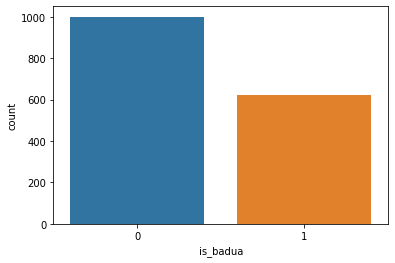

In [9]:
sns.countplot(x="is_badua" , data=df_useragents )
df_useragents['ua'][4]

In [10]:
# appending path for importing common process ua

import sys 
sys.path.append('/home/th3h04x/Documents/github/ProjectHeatBlast')



In [11]:
from ReverseProxy.utils.util import process_ua


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
#save the model
import pickle , joblib

def dump(model , filename):
    with open(filename, "wb") as f:
        joblib.dump(model , f)


x_train , x_test , y_train , y_test = train_test_split(df_useragents["ua"] ,df_useragents['is_badua'] , test_size=0.2) 


from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
cv = CountVectorizer(analyzer=process_ua)
cv.fit(x_train,y_train)
file_path = "../blasterModels/user_agents_models"

dump(cv , f"{file_path}/cv.pkl")

tfid = TfidfVectorizer(analyzer=process_ua)

cv = CountVectorizer(analyzer=process_ua)
X = cv.fit_transform(df_useragents["ua"])




In [13]:
# knc = KNeighborsClassifier(n_neighbors=100)

from sklearn.pipeline import Pipeline , make_pipeline

knn_cv_pipe = Pipeline([("count-vectorizer" , cv) , ("k-nearest neighbours" ,KNeighborsClassifier(n_neighbors=100)) ])
mnb_cv_pipe = Pipeline([("count-vectorizer" ,cv ), ("Multinomial-Naive-Bayes" ,MultinomialNB(alpha=0.5)) ])
svc_cv_pipe = Pipeline([("count-vectorizer" , cv ), ("Support-Vector-Classifier" ,SVC(kernel='sigmoid', gamma=1.0)) ])
dtc_cv_pipe = Pipeline([("count-vectorizer" , cv ), ("Decision-Tree-Classifier" ,DecisionTreeClassifier(min_samples_split=7, random_state=252)) ])
rf_cv_pipe = Pipeline([("count-vectorizer" ,cv ), ("RandomForest-Classifier" ,RandomForestClassifier(n_estimators=37, random_state=252)) ])
lg_cv_pipe = Pipeline([("count-vectorizer" , cv ), ("Logistic-Regression" ,LogisticRegression()) ])

knn_cv_pipe.fit(x_train , y_train)
mnb_cv_pipe.fit(x_train , y_train)
svc_cv_pipe.fit(x_train , y_train)
dtc_cv_pipe.fit(x_train , y_train)
rf_cv_pipe.fit(x_train,y_train)
lg_cv_pipe.fit(x_train,y_train)


file_path = "../blasterModels/user_agents_models"

dump(knn_cv_pipe , filename=f"{file_path}/knn_cv_pipe.pkl")
dump(mnb_cv_pipe , filename=f"{file_path}/mnb_cv_pipe.pkl")
dump(svc_cv_pipe , filename=f"{file_path}/svc_cv_pipe.pkl")
dump(dtc_cv_pipe , filename=f"{file_path}/dtc_cv_pipe.pkl" )
dump(rf_cv_pipe , filename=f"{file_path}/rf_cv_pipe.pkl")
dump(lg_cv_pipe , filename=f"{file_path}/lg_cv_pipe.pkl")

y_knn = knn_cv_pipe.predict(x_test)
y_mnb = mnb_cv_pipe.predict(x_test)
y_svc = svc_cv_pipe.predict(x_test)
y_dtc = dtc_cv_pipe.predict(x_test)
y_rfc = rf_cv_pipe.predict(x_test)
y_lg = lg_cv_pipe.predict(x_test)

print("[+] ACCURACY \n")
print("Kneighrest neighbours : " , accuracy_score(y_test , y_knn))
print("Multinomial Naive Bayes : " , accuracy_score(y_test , y_mnb))
print("Support Vector Classifier : " , accuracy_score(y_test , y_svc))
print("Decision Tree Classifier : " , accuracy_score(y_test , y_dtc))
print("Random Forest Classifier : " , accuracy_score(y_test , y_rfc))
print("Logistic Regression : " , accuracy_score(y_test , y_lg))



[+] ACCURACY 

Kneighrest neighbours :  0.9476923076923077
Multinomial Naive Bayes :  0.6430769230769231
Support Vector Classifier :  1.0
Decision Tree Classifier :  1.0
Random Forest Classifier :  1.0
Logistic Regression :  1.0


In [14]:
import pickle

file_path = "../blasterModels/user_agents_models/lg_cv_pipe.pkl"
with open(file_path , "wb") as f:
    pickle.dump(knn_cv_pipe , f)


with open(file_path , "rb") as f:
    m = pickle.load(f)
    print(m.predict(x_test))

[0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1
 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 0 1 0 0
 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 1
 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1
 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1
 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 1 1 0 1
 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0]
